In [1]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

from keyrover import *
from keyrover.vision import *
from keyrover.vision.models import BinarySegmentationModel
from keyrover.datasets import KeyboardBinaryMaskDataset

import wandb

wandb.login()
device

'mps'

In [2]:
SIZE = (480, 640)

train_dataset, valid_dataset, test_dataset = KeyboardBinaryMaskDataset.load("v4", size=SIZE)
len(train_dataset), len(valid_dataset), len(test_dataset)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


(8, 1, 1)

<class 'torch.Tensor'> (torch.float32, shape=torch.Size([1, 480, 640]))
        Min: 0.0
        Max: 1.0
        Mean: 0.11579752713441849
<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 480, 640]))
        Min: -1.2770130634307861
        Max: 2.1784777641296387
        Mean: 0.7093029618263245


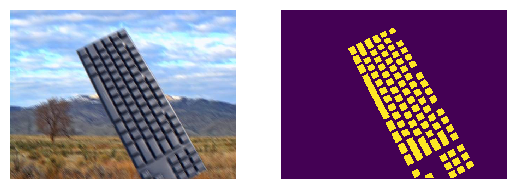

In [22]:
train_dataset.set_transforms([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
])

train_dataset.set_input_augmentations([
    # transforms.GaussianNoise(sigma=0.1, clip=True),
    # transforms.RandomApply([transforms.GaussianNoise(sigma=0.1, clip=False)], p=0.5),
], norm_params="default")

img, mask = train_dataset.random_img()
imshow(img, mask)

describe(mask)
describe(img)

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(train_dataset, valid_dataset, test_dataset,
                                                                         batch_size=32, num_workers=2,
                                                                         persistent_workers=True, pin_memory=True)

In [ ]:
wandb.finish()
model = BinarySegmentationModel("unet", "timm-regnetx_002", in_channels=3, out_classes=1, encoder_weights="imagenet", lr=2e-4)
model

In [ ]:
summarize(model)

In [ ]:
EPOCHS = 100

logger = WandbLogger(project="mrover-keyboard-region-segmentation")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
model.save(f"models/binary_segmentation/{wandb.run.name}-unet-timm-regnetx_002.pt")